<a href="https://colab.research.google.com/github/RodrigoAgronomia/workshop_esalq/blob/master/python/14_Semantic_Segmentation_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.4 Semantic segmenation with UNET

<img src="http://www.deeplearning.net/tutorial/_images/unet.jpg" style="height:500px">

In [0]:
%%capture
!pip install livelossplot
%cd /content
!git clone --depth 1 https://github.com/RodrigoAgronomia/workshop_esalq.git
%cd /content/workshop_esalq
!git pull
%cd /content/workshop_esalq/python

In [2]:
import os
import cv2
import time
import json
import numpy as np

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from livelossplot import PlotLosses
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [0]:
from cnn.unet import UNet

In [0]:
class MyDataset(Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, imList, labels):
        '''
        :param imList: image list (Note that these lists have been processed and pickled using the loadData.py)
        :param labelList: label list (Note that these lists have been processed and pickled using the loadData.py)
        '''          
        self.imList = imList
        self.labels = labels
        
    def __transform__(self, x):
        x = x.copy()
        x = np.moveaxis(x, 2, 0)
        x = x.astype('float')
        x -= 128
        x /= 35
        return(x)

    def __back_transform__(self, x):
        x = x.copy()
        x *= 35
        x += 128
        x[x<0] = 0
        x[x>255] = 255
        x = x.astype('uint8')
        x = np.moveaxis(x, 0, 2)
        return(x)

    def __len__(self):
        return len(self.imList)

    def __getitem__(self, idx):
        '''

        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        image_name = self.imList[idx]
        image = cv2.imread(image_name, cv2.IMREAD_COLOR)
        image = self.__transform__(image)
        image = torch.from_numpy(image)
        
        label = cv2.imread(self.labels[idx], cv2.IMREAD_GRAYSCALE)
        label = torch.from_numpy(label)
        
        image = Variable(image).to(device, dtype=torch.float)
        label = Variable(label).to(device, dtype=torch.long)
    
        return (image, label)

In [0]:
# Diretório das imagens
im_dir = '../data/seg/img/' 
lbl_dir = '../data/seg/pts_lr/'
img_ext = '.JPG'
msk_ext = '.png'

imfx = sorted(os.listdir(im_dir))
imfx = [i for i in imfx if i.endswith(img_ext)]
imfx = [os.path.join(im_dir,  imfx[i]) for i in range(len(imfx))]
imfx = np.array(imfx)

imfy = sorted(os.listdir(lbl_dir))
imfy = [i for i in imfy if i.endswith(msk_ext)]
imfy = [os.path.join(lbl_dir,  imfy[i]) for i in range(len(imfy))]
imfy = np.array(imfy)

im_train = np.arange(len(imfx))
im_val = np.random.choice(im_train, 10, replace=False)
im_train = np.setdiff1d(im_train, im_val)

In [0]:
# some labels
train_dataset =  MyDataset(imfx[im_train], imfy[im_train])
val_dataset =  MyDataset(imfx[im_val],  imfy[im_val])
test_dataset =  MyDataset(imfx,  imfy)


In [0]:
# Carrega o dataset de treinamento
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=2,
                          shuffle=True,
                          num_workers=0
                         )

# Carrega o dataset de validação
val_loader = torch.utils.data.DataLoader(val_dataset,
                          batch_size=1,
                          shuffle=False,
                          num_workers=0
                         )
test_loader = torch.utils.data.DataLoader(test_dataset,
                          batch_size=1,
                          shuffle=False,
                          num_workers=0
                         )

In [14]:
n_classes = 6
liveloss = PlotLosses()

# Atribui o modelo
model = UNet(in_channels = 3, n_classes= n_classes, depth = 3, padding=True, up_mode='upsample')
model = model.to(device)
# model.load_state_dict(torch.load('../data/model_seg_LR_best.pth'))
print('Modelo OK')

Modelo OK


In [15]:
# Apresenta um resumo das informações carregadas até o momento
# Input_size(numero de classes, tamanho da imagem - Resolução)
summary(model, input_size=(3, 960, 720))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 960, 720]           1,792
              ReLU-2         [-1, 64, 960, 720]               0
            Conv2d-3         [-1, 64, 960, 720]          36,928
              ReLU-4         [-1, 64, 960, 720]               0
     UNetConvBlock-5         [-1, 64, 960, 720]               0
            Conv2d-6        [-1, 128, 480, 360]          73,856
              ReLU-7        [-1, 128, 480, 360]               0
            Conv2d-8        [-1, 128, 480, 360]         147,584
              ReLU-9        [-1, 128, 480, 360]               0
    UNetConvBlock-10        [-1, 128, 480, 360]               0
           Conv2d-11        [-1, 256, 240, 180]         295,168
             ReLU-12        [-1, 256, 240, 180]               0
           Conv2d-13        [-1, 256, 240, 180]         590,080
             ReLU-14        [-1, 256, 2

In [0]:
weight = np.array([1,3,5,8,5,9])
weight = torch.from_numpy(weight).to(device, dtype=torch.float)
criterion = torch.nn.CrossEntropyLoss(weight)

In [0]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

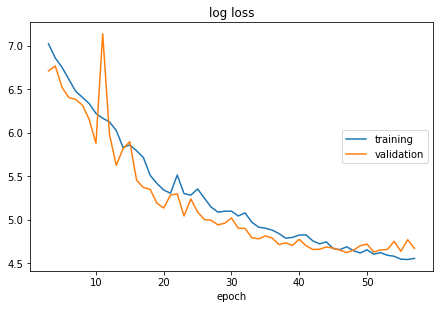

log loss:
training   (min:    4.544, max:    8.970, cur:    4.557)
validation (min:    4.624, max:    7.274, cur:    4.671)
[10:36] loss: 0.208 time:23.21


In [25]:
min_loss = 1e9
bad_epochs = 0

for epoch in range(100):
    bad_epochs += 1
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for (images, labels) in train_loader:
        
        # Limpa os gradientes
        optimizer.zero_grad()
    
        # Obtem o output
        outputs = model(images)

        # Caulcula a perda pela loss function
        loss = criterion(outputs, labels)

        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()
        
        epoch_loss.append(loss.data.item())
        
    for (images, labels) in val_loader:
        
        # Obtem o output
        outputs = model(images)

        # Caulcula a perda pela loss function (MSE)
        loss = criterion(outputs, labels)

        val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    #save the model
    model_file_name = '../data/model_seg_LR_best.pth'
    if val_loss < min_loss:
        torch.save(model.state_dict(), model_file_name)
        min_loss = val_loss
        bad_epochs = 0
    if bad_epochs > 10:
        break

    liveloss.update({
        'log loss': 10*np.sqrt(epoch_loss),
        'val_log loss': 10*np.sqrt(val_loss)
    })
    liveloss.draw()
    print('[%d:%d] loss: %.3f time:%.2f' % (bad_epochs, epoch, epoch_loss, time_taken))


In [26]:
# Carrega os pesos de um modelo salvo
model.load_state_dict(torch.load('../data/model_seg_LR_best.pth',map_location=device))

# Coloca em modo de avaliação
model.eval()

print('Modelo OK')

Modelo OK


In [0]:
#Define o mapa de cores para geração da máscara
def colorir(cat):
    h, w = cat.shape[:2]
    msk = np.zeros((h,w,3), dtype = 'uint8')
    msk[cat == 1] = [0,0,255]
    msk[cat == 2] = [128,0,0]
    msk[cat == 3] = [255,0,0]
    msk[cat == 4] = [0,128,0]
    msk[cat == 5] = [0,255,0]
    return(msk)

In [28]:
start_time = time.time()
y_preds = []
y_obs = []
x_obs = []

with torch.no_grad():
    for (images, labels) in test_loader:
        # Obtem o output
        
        pred = model(images)
        y_preds.append(pred.cpu().data.numpy())
        x_obs.append(images.cpu().data.numpy())
        y_obs.append(labels.cpu().data.numpy())

y_preds = np.concatenate(y_preds)
x_obs = np.concatenate(x_obs)
y_obs = np.concatenate(y_obs)

time_taken = time.time() - start_time
print('time:%.2f' % (time_taken))

time:12.03


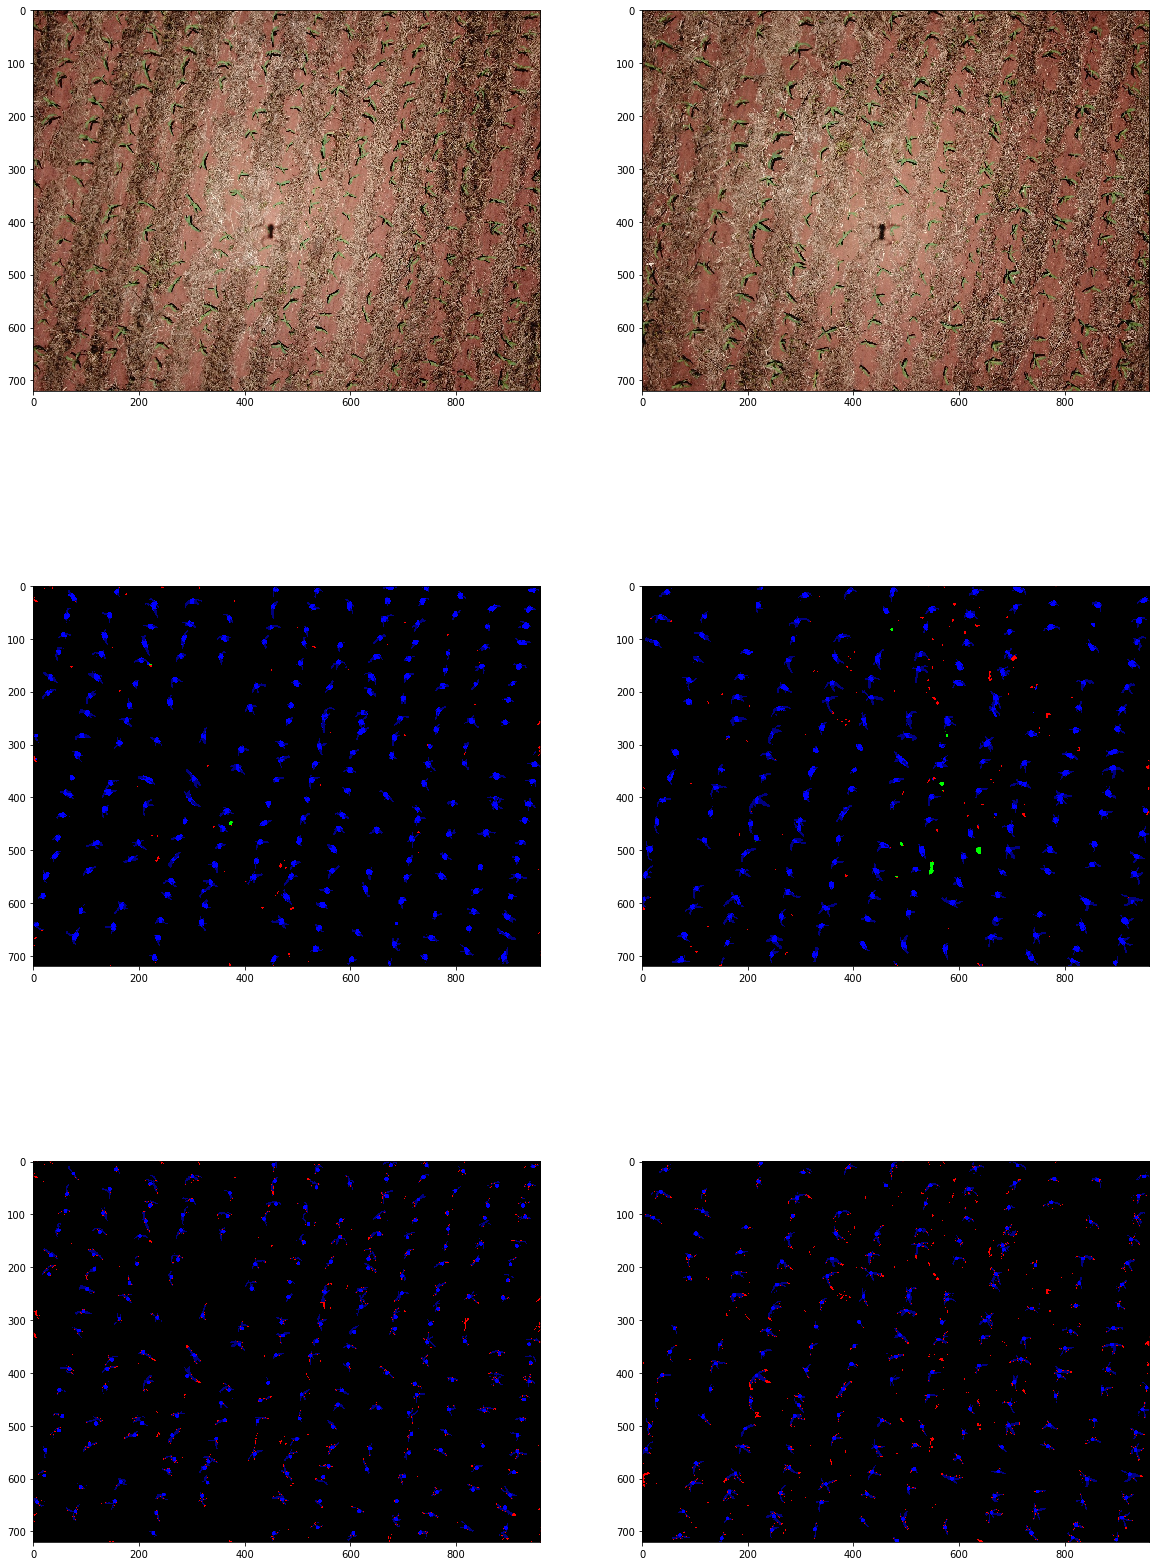

In [30]:
n_fig = 2
idx = np.random.choice(np.arange(len(y_obs)), n_fig)

f, ax = plt.subplots(nrows=3, ncols=n_fig,figsize=(20,30))
for i in range(n_fig):
    im = val_dataset.__back_transform__(x_obs[idx[i]])
    ax[0,i].imshow(im[:,:,[2,1,0]])
    
    msk = y_preds[idx[i]].argmax(0)
    ax[1,i].imshow(colorir(msk)[:,:,[2,1,0]])

    msk = y_obs[idx[i]]
    ax[2,i].imshow(colorir(msk)[:,:,[2,1,0]])